## IESO

In [227]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
# # load from github
# import urllib.request
# api_url = 'https://raw.githubusercontent.com/tanmayyb/ele70_bv03/refs/heads/main/api/datasets.py'
# exec(urllib.request.urlopen(api_url).read())

# load from local
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)
from api.datasets import IESODataset, Dataset

In [267]:
ieso = IESODataset('fsa')
ieso.load_dataset(start_date=202201, end_date=202301)
# ieso.load_dataset(start_date=2022, end_date=2023)
ieso.set_target(0)
ieso.target_name

Time range: 201801 to 202411


'Toronto'

| Property | FSA Type | Zonal Type |
|----------|----------|------------|
| dataset_type | "fsa" | "zonal" |
| region | Only "ON" supported | Only "ON" supported |
| target_options | List of Ontario cities | Fixed list: ["Northwest", "Northeast", "Ottawa", "East", "Toronto", "Essa", "Bruce", "Southwest", "Niagara", "West", "Zone Total"] |
| target_val | List of postal codes for selected city | Same as selected zone name |
| filetype | "zip" | "csv" |
| date_type | Monthly (YYYYMM) | Yearly (YYYY) |
| Data Granularity | FSA (Forward Sortation Area) level consumption | Zonal level demand |
| Data Format | Total consumption by postal code | Demand by geographical zone |


| Method | FSA Type | Zonal Type |
|--------|----------|------------|
| set_target(target_idx: int) | Sets city and corresponding postal codes<br>Example: set_target(0) might select "Toronto" and its FSAs | Sets single zone name<br>Example: set_target(4) selects "Toronto" zone |
| load_dataset(start_date, end_date, target_idx, download=True) | start_date: YYYYMM format (e.g., 201801)<br>end_date: YYYYMM format<br>Example: load_dataset(201801, 201812, 0, download=True) | start_date: YYYY format (e.g., 2018)<br>end_date: YYYY format<br>Example: load_dataset(2018, 2018, 4, download=True) |
| get_target_options() | Returns list of available cities | Returns list of 11 zones:<br>["Northwest", "Northeast", "Ottawa", etc.] |
| parse_dataset(chunk_size=4) | Processes FSA consumption data<br>Groups by DATE, HOUR for selected postal codes | Processes zonal demand data<br>Direct selection of zone column |
| save_dataset(filepath=None) | Saves data with FSA metadata:<br>- City name<br>- Postal codes<br>- Monthly files | Saves data with zonal metadata:<br>- Zone name<br>- Yearly files |
| load_from_json(filepath=None) | Loads FSA dataset with:<br>- Consumption by postal code<br>- DateTime in monthly granularity | Loads zonal dataset with:<br>- Demand by zone<br>- DateTime in yearly granularity |

## Climate

In [294]:
from meteostat import Stations, Hourly
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point


class ClimateDataset(Dataset):
  def __init__(self, iesodata: IESODataset, region: str = "ON", 
               sampling_seed: int = 42, sample_num: int = 5):
    super().__init__(region, "CA")
    self.dataset_type = "CLIMATE"
    self.ieso_dataset = iesodata
    
    if hasattr(self.ieso_dataset, 'target_name'):
      self.target_name = self.ieso_dataset.target_name
    else:
      raise ValueError("IESO dataset does not have target name")  
    if self.target_name is None:
      raise ValueError("IESO dataset target name is not set")

    self.weather_station_ids = None

    # need from IESO dataset
    # need to error check
    # self.ieso_dataset_type = None
    # self.ieso_target = None
    # self.ieso_target_val = None
    self.range = None

  def load_dataset(self):
    self.get_weather_stations()
    # choose N number of weather stations randomly
    # error check weather station data
    # combine weather station data into single dataframe
    # save to csv
    

  def get_weather_stations(self):
    dataset_type = self.ieso_dataset.dataset_type

    if dataset_type == 'zonal':
      self.get_zone_based_weather_stations()
    elif dataset_type == 'fsa':
      self.get_location_based_weather_stations()
    else:
      raise ValueError("Unknown dataset type, cannot resolve weather stations!")
    


  def filter_stations(self,):
    stations = self.weather_stations
    stations = stations.dropna(subset=['wmo'])

  def get_zone_based_weather_stations(self):
    target = self.target_name
    geojson_url = 'https://raw.githubusercontent.com/tanmayyb/ele70_bv03/refs/heads/main/api/ieso_zones.geojson'

    # read zonal geojson for zonal geometry
    zones = gpd.read_file(geojson_url).to_crs("EPSG:4326")
    zones.set_index('Name', inplace=True)
    def convert_to_tuple(coord_str):
        return tuple(map(float, coord_str.strip('()').split(', ')))
    zones['top_left'] = zones['top_left'].apply(convert_to_tuple)
    zones['bottom_right'] = zones['bottom_right'].apply(convert_to_tuple)    

    # make bounding box
    top_left = zones.loc[target].top_left
    bottom_right = zones.loc[target].bottom_right
    zone_geometry = zones.loc[target].geometry
    def is_within_zone(station):
        point = Point(station['longitude'], station['latitude'])
        return point.within(zone_geometry)

    # fetch stations in bounding box
    stations = Stations().region(self.country)
    stations = stations.bounds(top_left, bottom_right) 
    stations = stations.fetch()
    filtered_stations = stations[stations.apply(is_within_zone, axis=1)] # filter stations within zone geometry
    # self.weather_station_ids = filtered_stations['id'].tolist()
    self.weather_stations = filtered_stations

  def get_location_based_weather_stations(self):
    target = self.target_name
    
    geolocator = Nominatim(user_agent="geoapi")
    location = geolocator.geocode(f"{target}, {self.region}")
    stations = Stations().region(self.country)
    stations = stations.nearby(location.latitude, location.longitude)
    stations = stations.fetch()
    self.weather_stations = stations


In [295]:
climate = ClimateDataset(ieso)
climate.load_dataset()
climate.ieso_dataset.dataset_type


'fsa'

In [296]:
climate.weather_stations.dropna(subset=['wmo'])

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
71508,Toronto City,CA,ON,71508,CXTO,43.6700,-79.4000,112.0,America/Toronto,2004-08-03,2025-03-06,2002-06-04,2025-02-27,2002-01-01,2022-01-01,2.245827e+03
2XUGG,Toronto City Centre,CA,ON,71265,<NA>,43.6300,-79.4000,77.0,America/Toronto,2020-01-01,2022-12-14,2010-02-02,2022-12-11,2010-01-01,2022-01-01,2.913547e+03
71624,Toronto Pearson International Airport,CA,ON,71624,CYYZ,43.6800,-79.6300,173.0,America/Toronto,1950-01-01,2025-03-06,1937-11-01,2022-12-11,1937-01-01,2022-01-01,2.001067e+04
71639,Toronto Buttonville Airport,CA,ON,71639,CYKZ,43.8600,-79.3700,198.0,America/Toronto,1986-06-20,2019-01-03,1986-05-23,2019-01-02,1986-01-01,2018-01-01,2.299104e+04
8IOCM,King City North,CA,ON,73074,<NA>,43.9600,-79.5700,361.0,America/Toronto,2020-01-01,2023-11-30,2019-09-17,2022-12-12,2019-01-01,2022-01-01,3.721032e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71044,Old Crow RCS,CA,YT,71044,CZOC,67.5700,-139.8400,251.0,America/Dawson,1996-05-01,2022-12-14,1995-11-10,2024-04-28,1995-01-01,2022-01-01,4.366369e+06
71978,Ivvavik National Park,CA,YT,71978,CWOI,69.1600,-140.1500,244.0,America/Dawson,1995-09-01,2025-02-05,1995-07-22,2024-04-28,1995-01-01,2021-01-01,4.400018e+06
71969,Komakuk Beach Airport,CA,YT,71969,CYAJ,69.5833,-140.1833,7.0,America/Dawson,1978-01-01,1993-06-30,1958-07-01,1993-06-29,1958-01-01,1993-01-01,4.407758e+06


In [281]:
climate.weather_stations.head()

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
71508,Toronto City,CA,ON,71508,CXTO,43.6700,-79.40,112.0,America/Toronto,2004-08-03,2025-03-06,2002-06-04,2025-02-27,2002-01-01,2022-01-01,2245.827242
71265,Toronto Island Airport,CA,ON,<NA>,CYTZ,43.6333,-79.40,77.0,America/Toronto,1979-05-07,2025-03-06,1957-05-01,2022-04-26,1957-01-01,2022-01-01,2589.807478
2XUGG,Toronto City Centre,CA,ON,71265,<NA>,43.6300,-79.40,77.0,America/Toronto,2020-01-01,2022-12-14,2010-02-02,2022-12-11,2010-01-01,2022-01-01,2913.547421
8PJPB,Toronto East York Dustan,CA,ON,<NA>,<NA>,43.7000,-79.34,125.0,America/Toronto,NaT,NaT,2007-05-25,2015-07-31,2007-01-01,2015-01-01,6264.178636
NZY2Y,Toronto North York,CA,ON,<NA>,<NA>,43.7800,-79.47,187.0,America/Toronto,NaT,NaT,2000-01-01,2022-06-10,2000-01-01,2020-01-01,15676.645906


In [313]:
climate.weather_stations

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
71508,Toronto City,CA,ON,71508,CXTO,43.6700,-79.4000,112.0,America/Toronto,2004-08-03,2025-03-06,2002-06-04,2025-02-27,2002-01-01,2022-01-01,2.245827e+03
71265,Toronto Island Airport,CA,ON,<NA>,CYTZ,43.6333,-79.4000,77.0,America/Toronto,1979-05-07,2025-03-06,1957-05-01,2022-04-26,1957-01-01,2022-01-01,2.589807e+03
2XUGG,Toronto City Centre,CA,ON,71265,<NA>,43.6300,-79.4000,77.0,America/Toronto,2020-01-01,2022-12-14,2010-02-02,2022-12-11,2010-01-01,2022-01-01,2.913547e+03
8PJPB,Toronto East York Dustan,CA,ON,<NA>,<NA>,43.7000,-79.3400,125.0,America/Toronto,NaT,NaT,2007-05-25,2015-07-31,2007-01-01,2015-01-01,6.264179e+03
NZY2Y,Toronto North York,CA,ON,<NA>,<NA>,43.7800,-79.4700,187.0,America/Toronto,NaT,NaT,2000-01-01,2022-06-10,2000-01-01,2020-01-01,1.567665e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CYXQ0,Beaver Creek,CA,YT,<NA>,CYXQ,62.4103,-140.8675,649.0,America/Whitehorse,1943-08-20,2025-03-05,1944-03-29,1947-12-31,1944-01-01,1947-01-01,4.390680e+06
71978,Ivvavik National Park,CA,YT,71978,CWOI,69.1600,-140.1500,244.0,America/Dawson,1995-09-01,2025-02-05,1995-07-22,2024-04-28,1995-01-01,2021-01-01,4.400018e+06
71969,Komakuk Beach Airport,CA,YT,71969,CYAJ,69.5833,-140.1833,7.0,America/Dawson,1978-01-01,1993-06-30,1958-07-01,1993-06-29,1958-01-01,1993-01-01,4.407758e+06


In [302]:
from meteostat import Hourly


In [311]:
help(Hourly)

Help on class Hourly in module meteostat.interface.hourly:

class Hourly(meteostat.interface.timeseries.TimeSeries)
 |  Hourly(loc: Union[pandas.core.frame.DataFrame, meteostat.interface.point.Point, list, str], start: datetime.datetime = None, end: datetime.datetime = None, timezone: str = None, model: bool = True, flags: bool = False) -> None
 |
 |  Retrieve hourly weather observations for one or multiple weather stations or
 |  a single geographical point
 |
 |  Method resolution order:
 |      Hourly
 |      meteostat.interface.timeseries.TimeSeries
 |      meteostat.interface.meteodata.MeteoData
 |      meteostat.interface.base.Base
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, loc: Union[pandas.core.frame.DataFrame, meteostat.interface.point.Point, list, str], start: datetime.datetime = None, end: datetime.datetime = None, timezone: str = None, model: bool = True, flags: bool = False) -> None
 |      Initialize self.  See help(type(self)) for accurate

In [314]:
df = Hourly(71265)
df.fetch()


,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
1979-05-07 11:00:00,7.0,4.0,81.0,NaN,NaN,70.0,31.3,NaN,1018.8,NaN,NaN
1979-05-07 12:00:00,8.0,4.0,76.0,NaN,NaN,70.0,36.7,NaN,1019.2,NaN,NaN
1979-05-07 13:00:00,8.0,4.0,76.0,NaN,NaN,70.0,36.7,NaN,1019.2,NaN,NaN
1979-05-07 14:00:00,8.0,4.9,81.0,NaN,NaN,70.0,36.7,NaN,1019.2,NaN,NaN
1979-05-07 15:00:00,8.0,4.0,76.0,NaN,NaN,70.0,33.1,NaN,1019.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-14 00:00:00,8.3,7.9,97.0,NaN,NaN,260.0,14.0,NaN,997.7,NaN,NaN
2025-03-14 06:00:00,-0.4,-3.1,82.0,NaN,NaN,320.0,26.3,NaN,1004.3,NaN,NaN
2025-03-14 12:00:00,-2.0,-5.5,77.0,NaN,NaN,339.0,21.2,NaN,1012.9,NaN,NaN


In [308]:
data = Hourly(idx)


In [310]:
data.fetch()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2004-08-03 12:00:00,21.7,19.1,85.0,NaN,NaN,NaN,NaN,NaN,1011.0,NaN,NaN
2004-08-03 18:00:00,26.3,22.4,79.0,NaN,NaN,NaN,NaN,NaN,1009.7,NaN,NaN
2004-08-04 00:00:00,26.3,19.9,68.0,NaN,NaN,NaN,NaN,NaN,1009.1,NaN,NaN
2004-08-04 06:00:00,20.2,18.3,89.0,NaN,NaN,NaN,NaN,NaN,1009.3,NaN,NaN
2004-08-04 12:00:00,20.5,18.3,87.0,NaN,NaN,NaN,NaN,NaN,1009.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-11 12:00:00,-7.7,-10.7,79.0,NaN,NaN,169.0,10.4,NaN,1021.4,NaN,NaN
2025-03-11 18:00:00,2.9,-2.2,69.0,NaN,NaN,174.0,13.7,NaN,1014.1,NaN,NaN
2025-03-12 00:00:00,7.9,2.4,68.0,NaN,NaN,228.0,24.8,NaN,1009.5,NaN,NaN


## MISC

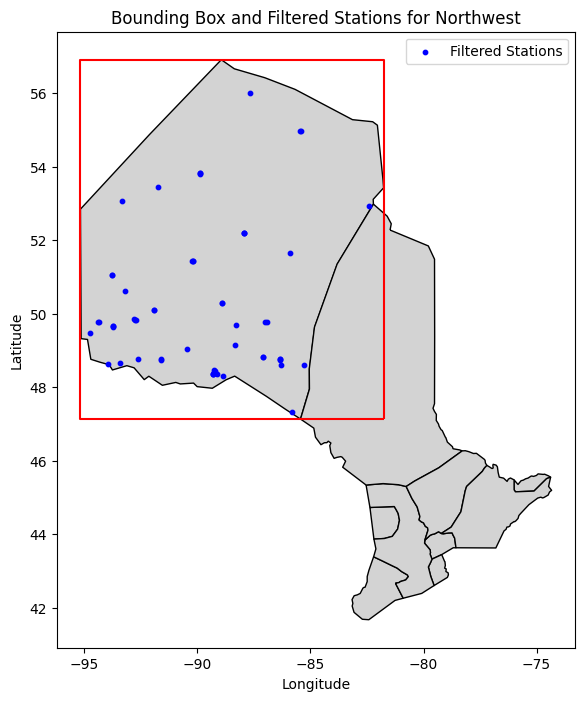

In [225]:
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely.geometry import Point

geojson_file = r'C:\Users\tanma\Documents\github\capstone\api\ieso_zones.geojson'
zones = gpd.read_file(geojson_file).to_crs("EPSG:4326")
zones.set_index('Name', inplace=True)
def convert_to_tuple(coord_str):
    return tuple(map(float, coord_str.strip('()').split(', ')))
zones['top_left'] = zones['top_left'].apply(convert_to_tuple)
zones['bottom_right'] = zones['bottom_right'].apply(convert_to_tuple)

zone = 'Northwest'
top_left = zones.loc[zone].top_left
bottom_right = zones.loc[zone].bottom_right
zone_geometry = zones.loc[zone].geometry

maxy, minx = zones.loc[zone].top_left
miny, maxx = zones.loc[zone].bottom_right

def is_within_zone(station):
    point = Point(station['longitude'], station['latitude'])
    return point.within(zone_geometry)

stations = Stations().region('CA')
stations = stations.bounds(top_left, bottom_right)
stations = stations.fetch()
filtered_stations = stations[stations.apply(is_within_zone, axis=1)]

plot = True
if plot:
  # Create a GeoDataFrame for the bounding box
  bbox = gpd.GeoDataFrame({'geometry': [shapely.geometry.box(minx, miny, maxx, maxy)]}, crs="EPSG:4326")

  # Plot the zones, the bounding box, and the filtered stations
  fig, ax = plt.subplots(figsize=(10, 8))
  zones.plot(ax=ax, color='lightgrey', edgecolor='black')
  bbox.boundary.plot(ax=ax, color='red')

  # Plot the filtered stations
  ax.scatter(filtered_stations['longitude'], filtered_stations['latitude'], color='blue', label='Filtered Stations', s=10)

  # Set labels and title
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')
  ax.set_title(f'Bounding Box and Filtered Stations for {zone}')
  ax.legend()

  # Show the plot
  plt.show()

In [ ]:
# class DatasetLoader():
#   def __init__(self, dataset: Dataset):
#     self.dataset = dataset

#   def load_dataset(self, dataset, start_date: int = None, end_date: int = None, download: bool = False):
#     if start_date > end_date:
#       raise ValueError("Start date must be before end date")

#     files = dataset.files
#     file_type = dataset.filetype
#     dates = dataset.dates
#     date_type = dataset.date_type

#     if download:
#       self.dataset.download_dataset()
#     else:
#       self.dataset.load_dataset_from_local()

  # def download_dataset(self, dataset, file_type, date_type, start_date: int, end_date: int):
  # # make sure data folder exists
  #   if file_type == "zip":
  #     self.download_zip_dataset(files, dates, date_type)
  #   elif file_type == "csv":
  #     self.download_csv_dataset(files, dates, date_type)

  # def download_zip_dataset(self, files, dates, date_type):
  #   for file in files:
  #     url = file